## Basic Setup

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.quiet(quietval=True)
seed = 24
np.random.seed(seed)

resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ez,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,resolution=design_region_resolution)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Ez0 = mpa.Ez_Coefficients(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(2,0,0)))
ob_list = [Ez0]



def J1(alpha):
    return npa.abs(alpha[0,0]) **2


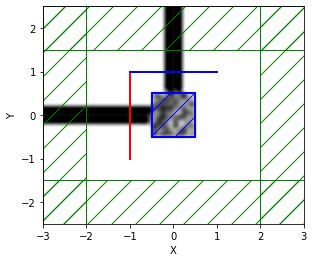

In [2]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)


Nx = design_variables.Nx # number of parameters in the x direction
Ny = design_variables.Ny # number of parameters in the y direction
x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])


opt.plot2D(True)
plt.show()



Starting forward run...
Starting adjoint run...
Calculating gradient...


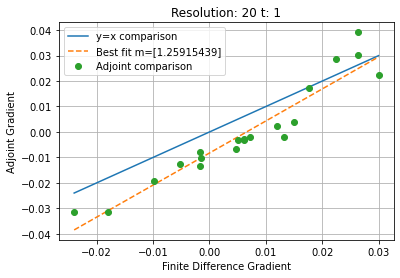

Starting forward run...
Starting adjoint run...
Calculating gradient...


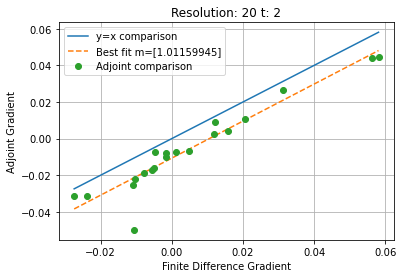

Starting forward run...
Starting adjoint run...
Calculating gradient...


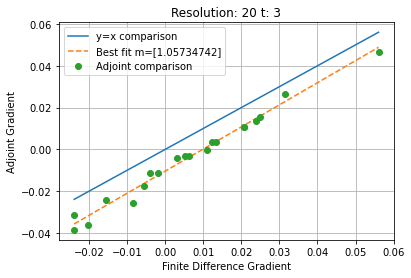

Starting forward run...
Starting adjoint run...
Calculating gradient...


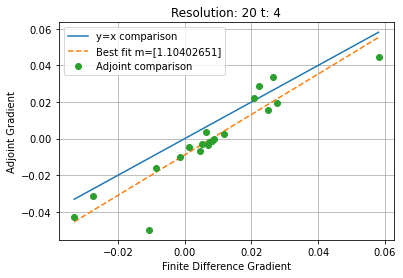

Starting forward run...
Starting adjoint run...
Calculating gradient...


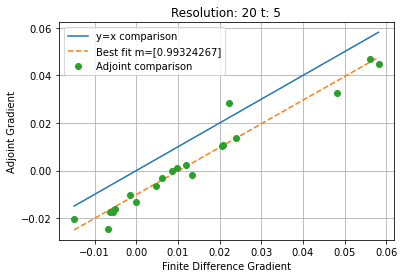

Starting forward run...
Starting adjoint run...
Calculating gradient...


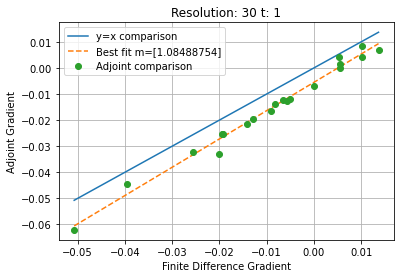

Starting forward run...
Starting adjoint run...
Calculating gradient...


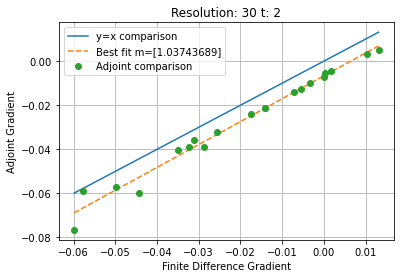

Starting forward run...
Starting adjoint run...
Calculating gradient...


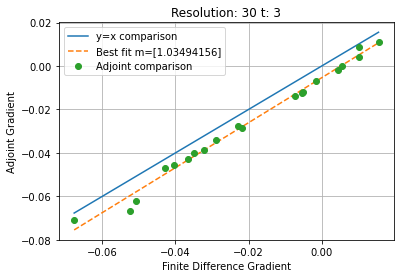

Starting forward run...
Starting adjoint run...
Calculating gradient...


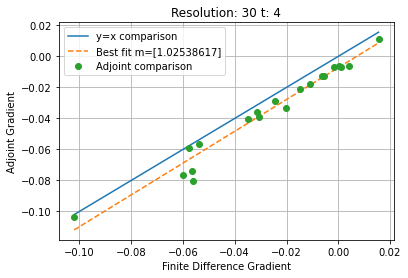

Starting forward run...
Starting adjoint run...
Calculating gradient...


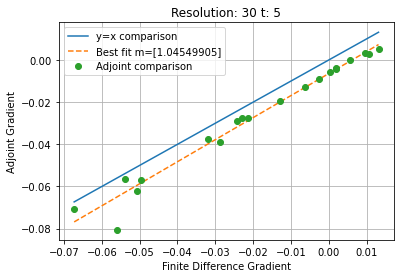

Starting forward run...
Starting adjoint run...
Calculating gradient...


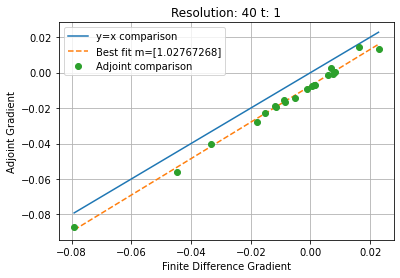

Starting forward run...
Starting adjoint run...
Calculating gradient...


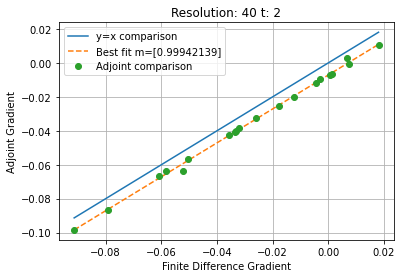

Starting forward run...
Starting adjoint run...
Calculating gradient...


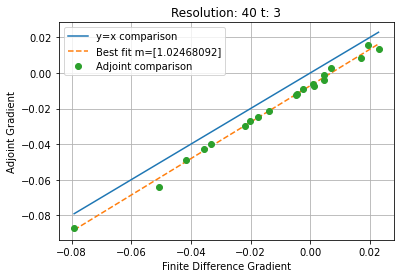

Starting forward run...
Starting adjoint run...
Calculating gradient...


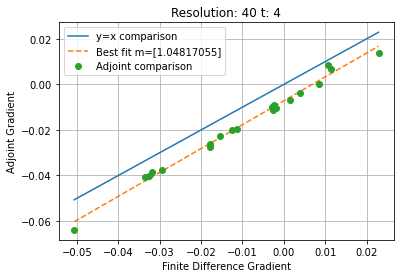

Starting forward run...
Starting adjoint run...
Calculating gradient...


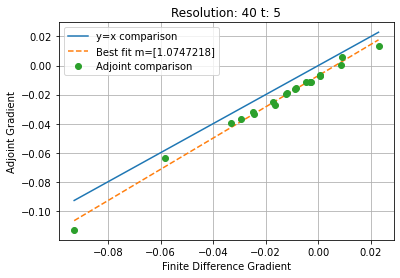

Starting forward run...
Starting adjoint run...
Calculating gradient...


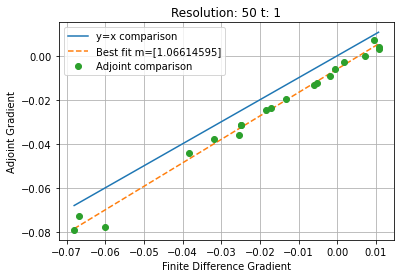

Starting forward run...
Starting adjoint run...
Calculating gradient...


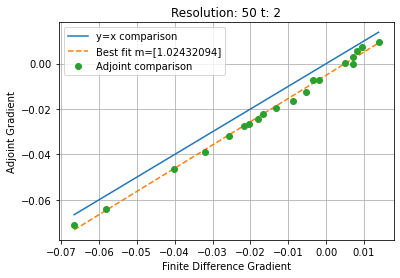

Starting forward run...
Starting adjoint run...
Calculating gradient...


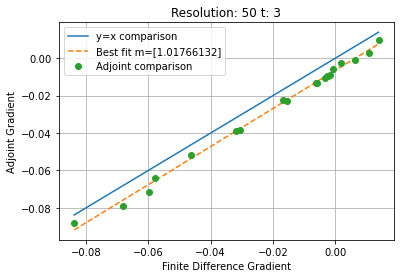

Starting forward run...
Starting adjoint run...
Calculating gradient...


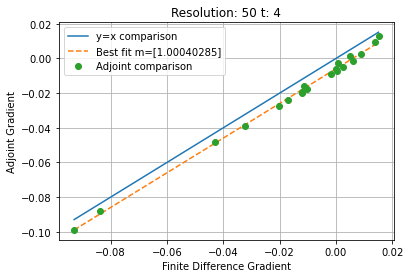

Starting forward run...
Starting adjoint run...
Calculating gradient...


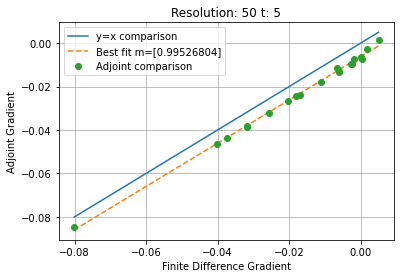

Starting forward run...
Starting adjoint run...
Calculating gradient...


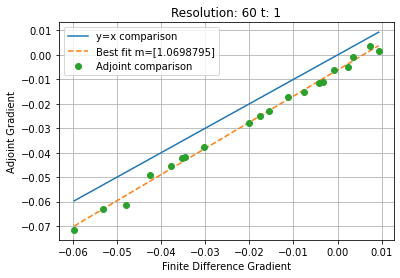

Starting forward run...
Starting adjoint run...
Calculating gradient...


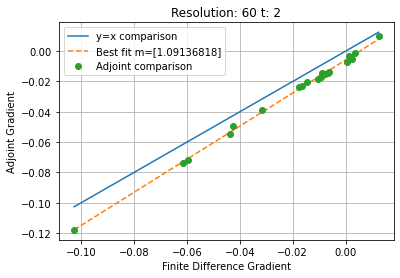

Starting forward run...
Starting adjoint run...
Calculating gradient...


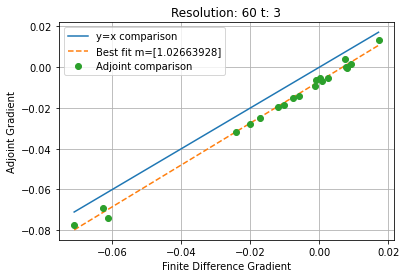

Starting forward run...
Starting adjoint run...
Calculating gradient...


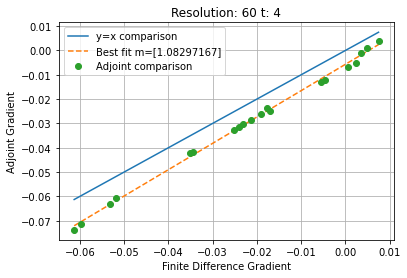

Starting forward run...
Starting adjoint run...
Calculating gradient...


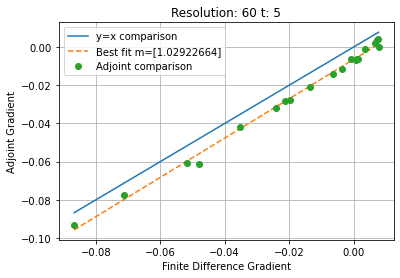

In [5]:
db = 1e-3
choose = 20
m_table = np.zeros((5,5))
b_table = np.zeros((5,5))
residue_table = np.zeros((5,5))
for resolution_idx in range(5):
    for t in range(5):
        resolution = (resolution_idx + 2)*10
        opt.sim.resolution = resolution
        f0, dJ_deps, dg = opt()
        g_adjoint = design_variables.get_basis_vjp(dJ_deps,dg)
        g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)


        (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
        min_g = np.min(g_discrete)
        max_g = np.max(g_discrete)
        residue = np.sum((m * g_discrete + b - g_adjoint[idx])**2)
        
        m_table[t, resolution_idx] = m
        b_table[t, resolution_idx] = b
        residue_table[t, resolution_idx] = residue

        plt.figure()
        plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
        plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
        plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
        plt.xlabel('Finite Difference Gradient')
        plt.ylabel('Adjoint Gradient')
        plt.title('Resolution: {} t: {}'.format(resolution,t+1))
        plt.legend()
        plt.grid(True)
        plt.show()

In [6]:
b_table

array([[-0.00826147, -0.00552459, -0.00741896, -0.00602364, -0.00615602],
       [-0.01066584, -0.00669796, -0.00714042, -0.00508727, -0.00580372],
       [-0.01041278, -0.00539972, -0.00715779, -0.00651566, -0.00688607],
       [-0.00887275, -0.00729961, -0.00721372, -0.00593515, -0.00570414],
       [-0.01012209, -0.00643434, -0.00694612, -0.00628535, -0.00647895]])

In [7]:
np.sum(b_table, axis=0)

array([-0.04833495, -0.03135622, -0.03587701, -0.02984707, -0.0310289 ])

In [8]:
residue_table

array([[0.26643027, 0.25180252, 0.42322839, 0.53500224, 0.39761841],
       [0.42205408, 0.39782047, 0.70626279, 0.39403658, 0.72465932],
       [0.35374104, 0.48406489, 0.52877711, 0.64796761, 0.50744973],
       [0.40277678, 0.70618911, 0.291372  , 0.65440896, 0.43008451],
       [0.331763  , 0.54113306, 0.56649556, 0.31421474, 0.62471672]])

In [9]:
np.sum(residue_table, axis=0)

array([1.77676517, 2.38101004, 2.51613585, 2.54563013, 2.68452869])

In [2]:
import numpy as np
b = np.array([[-0.00826147, -0.00552459, -0.00741896, -0.00602364, -0.00615602],
       [-0.01066584, -0.00669796, -0.00714042, -0.00508727, -0.00580372],
       [-0.01041278, -0.00539972, -0.00715779, -0.00651566, -0.00688607],
       [-0.00887275, -0.00729961, -0.00721372, -0.00593515, -0.00570414],
       [-0.01012209, -0.00643434, -0.00694612, -0.00628535, -0.00647895]])

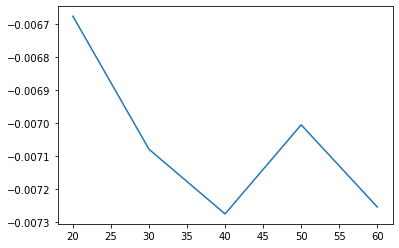

In [3]:
from matplotlib import pyplot as plt
res = [20,30, 40, 50, 60]
plt.plot(res, b.sum(axis=1)/5)